# Convert a PaddlePaddle Model to ONNX and OpenVINO™ IR

This notebook shows how to convert a MobileNetV3 model from [PaddleHub](https://github.com/PaddlePaddle/PaddleHub), pretrained on the [ImageNet](https://www.image-net.org) dataset, to OpenVINO IR. It also shows how to perform classification inference on a sample image using [OpenVINO Runtime](https://docs.openvino.ai/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and compares the results of the [PaddlePaddle](https://github.com/PaddlePaddle/Paddle) model with the IR model. 

Source of the [model](https://www.paddlepaddle.org.cn/hubdetail?name=mobilenet_v3_large_imagenet_ssld&en_category=ImageClassification).

## Preparation

### Imports

In [1]:
import time
import sys
import tarfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
from PIL import Image
from openvino.runtime import Core
sys.path.append("../utils")
from notebook_utils import download_file

### Settings

Set `IMAGE_FILENAME` to the filename of an image to use. Set `MODEL_NAME` to the PaddlePaddle model to download from PaddleHub. `MODEL_NAME` will also be the base name for the IR model. The notebook is tested with the [mobilenet_v3_large_x1_0](https://github.com/PaddlePaddle/PaddleClas/blob/release/2.5/docs/en/models/Mobile_en.md) model. Other models may use different preprocessing methods and therefore require some modification to get the same results on the original and converted model.

First of all, we need to download and unpack model files.
The first time you run this notebook, the PaddlePaddle model is downloaded from PaddleHub. This may take a while.

In [2]:
IMAGE_FILENAME = "coco_close.png"

MODEL_NAME = "MobileNetV3_large_x1_0"
MODEL_DIR = Path("model")
if not MODEL_DIR.exists():
    MODEL_DIR.mkdir()
MODEL_URL = 'https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/inference/{}_infer.tar'.format(MODEL_NAME)
download_file(MODEL_URL, directory=MODEL_DIR)
file = tarfile.open(MODEL_DIR / '{}_infer.tar'.format(MODEL_NAME))
res = file.extractall(MODEL_DIR)
if not res:
    print(f"Model Extracted to \"./{MODEL_DIR}\".")
else:
    print("Error Extracting the model. Please check the network.")

model/MobileNetV3_large_x1_0_infer.tar:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

Model Extracted to "./model".


## Show Inference on PaddlePaddle Model

In the next cell, we load model, read and display an image, do inference on that image, and show the top three prediction results.

/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddle/vision/transforms/functional_pil.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': Image.NEAREST,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddle/vision/transforms/functional_pil.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': Image.BILINEAR,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddle/vision/transforms/functional_pil.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': Image.BICUBIC,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddle/vision/transforms/functional_pil.py:39: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  'box': 

[2022/11/30 08:11:07] ppcls WARNING: The current running environment does not support the use of GPU. CPU has been used instead.


/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddleclas/deploy/python/preprocess.py:67: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': Image.NEAREST,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddleclas/deploy/python/preprocess.py:68: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': Image.BILINEAR,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddleclas/deploy/python/preprocess.py:69: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': Image.BICUBIC,
/home/ea/work/notebooks_env/lib/python3.8/site-packages/paddleclas/deploy/python/preprocess.py:70: DeprecationWarning: BOX is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BOX instead.
  'box': Image.BOX,
/home

Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


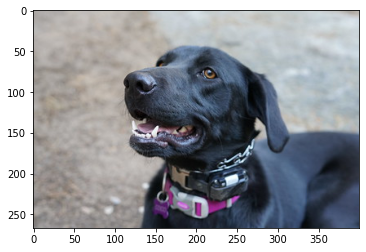

In [3]:
from paddleclas import PaddleClas
classifier = PaddleClas(inference_model_dir=MODEL_DIR / '{}_infer'.format(MODEL_NAME))
result=next(classifier.predict(IMAGE_FILENAME))
class_names = result[0]['label_names']
scores = result[0]['scores']
image = Image.open(IMAGE_FILENAME)
plt.imshow(image)
for class_name, softmax_probability in zip(class_names, scores):
    print(f"{class_name}, {softmax_probability:.5f}")

`classifier.predict()` takes an image file name, reads image and preprocesses input and returns the class labels and scores of the image. Preprocessing the image is done behind the scenes. The classification model returns an array with floating point values for each of the 1000 ImageNet classes. The higher the value, the more confident the network is that the class number corresponding to that value (the index of that value in the network output array) is the class number for the image. 

To see PaddlePaddle's implementation for the classification function and for loading and preprocessing data, uncomment the next two cells.

In [4]:
#classifier??

In [5]:
#classifier.get_config()

The `classifier.get_config()` module shows preprocewssing configuration for model. it should be seen that images are normalized, resized and cropped and that the BGR image is converted to RGB before propagating through the network. In the next cell, we get the `classifier.predictror.preprocess_ops` propertiy that returns list of preprocessing operation to do inference on the OpenVINO IR model with the same method. 

In [6]:
preprocess_ops = classifier.predictor.preprocess_ops

def process_image(image):
    for op in  preprocess_ops:
        image = op(image)
    return image

It is useful to show the output of the `process_image()` function, to see the effect of cropping and resizing. Because of the normalization, the colors will look strange, and matplotlib will warn about clipping values. 

2022-11-30 08:11:08 WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Processed image shape: (3, 224, 224)


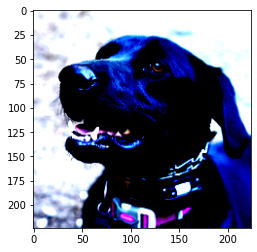

In [7]:
pil_image = Image.open(IMAGE_FILENAME)
processed_image = process_image(np.array(pil_image))
print(f"Processed image shape: {processed_image.shape}")
# Processed image is in (C,H,W) format, convert to (H,W,C) to show the image
plt.imshow(np.transpose(processed_image, (1, 2, 0)))

For decoding lables predicted by model to names of classes, we need to have mapping between them, model config contains information about `class_id_map_file`, which store such mapping. The code below, shows how to parse it to dictionary for using with openvino model.

In [8]:
class_id_map_file = classifier.get_config()['PostProcess']['Topk']['class_id_map_file']
class_id_map = {}
with open(class_id_map_file, "r") as fin:
    lines = fin.readlines()
    for line in lines:
        partition = line.split("\n")[0].partition(" ")
        class_id_map[int(partition[0])] = str(partition[-1])


## Convert the Model to OpenVINO IR Format

Call the OpenVINO Model Optimizer tool to convert the PaddlePaddle model to OpenVINO IR, with FP32 precision. The models are saved to the current directory. We can add the mean values to the model with `--mean_values` and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network. However, to get the exact same output as the PaddlePaddle model, it is necessary to preprocess in the image in the same way. For this tutorial, we therefore do not add the mean and scale values to the model, and we use the `process_image` function, as described in the previous section, to ensure that both the IR and the PaddlePaddle model use the same preprocessing methods. We do show how to get the mean and scale values of the PaddleGAN model, so you can add them to the Model Optimizer command if you want. See the [PyTorch/ONNX to OpenVINO](../102-pytorch-onnx-to-openvino/102-pytorch-onnx-to-openvino.ipynb) notebook for a notebook where these options are used.

Run `! mo --help` in a code cell to show an overview of command line options for Model Optimizer. See the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

In the next cell, we first construct the command for Model Optimizer, and then execute this command in the notebook by prepending the command with a `!`. When Model Optimization is successful, the last lines of the output include `[ SUCCESS ] Generated IR version 11 model`.

In [9]:
model_xml = Path(MODEL_NAME).with_suffix('.xml')
if not model_xml.exists():
    mo_command = f'mo --input_model model/MobileNetV3_large_x1_0_infer/inference.pdmodel --model_name {MODEL_NAME}'
    display(Markdown(f"Model Optimizer command to convert the ONNX model to IR: `{mo_command}`"))
    display(Markdown("_Converting model to IR. This may take a few minutes..._"))
    ! $mo_command
else:
    print(f"{model_xml} already exists.")

Model Optimizer command to convert the ONNX model to IR: `mo --input_model model/MobileNetV3_large_x1_0_infer/inference.pdmodel --model_name MobileNetV3_large_x1_0`

_Converting model to IR. This may take a few minutes..._

[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /home/ea/work/openvino_notebooks/notebooks/103-paddle-onnx-to-openvino/MobileNetV3_large_x1_0.xml
[ SUCCESS ] BIN file: /home/ea/work/openvino_notebooks/notebooks/103-paddle-onnx-to-openvino/MobileNetV3_large_x1_0.bin


## Show Inference on OpenVINO Model

Load the IR model, get model information, load the image, do inference, convert the inference to a meaningful result, and show the output. See the [OpenVINO Runtime API Notebook](../002-openvino-api/002-openvino-api.ipynb) for more information.

Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848


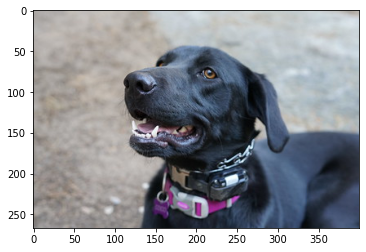

In [11]:
# Load OpenVINO Runtime and OpenVINO IR model
ie = Core()
model = ie.read_model(model_xml)
compiled_model = ie.compile_model(model=model, device_name="CPU")

# Get model output
output_layer = compiled_model.output(0)

# Read, show, and preprocess input image
# See the "Show Inference on PaddlePaddle Model" section for source of process_image
image = Image.open(IMAGE_FILENAME)
plt.imshow(image)
input_image = process_image(np.array(image))[None,]

# Do inference
ie_result = compiled_model([input_image])[output_layer][0]

# find the top three values
top_indices = np.argsort(ie_result)[-3:][::-1]
top_scores = ie_result[top_indices]

# Convert the inference results to class names, using the same labels as the PaddlePaddle classifier
for index, softmax_probability in zip(top_indices, top_scores):
    print(f"{class_id_map[index]}, {softmax_probability:.5f}")

## Timing and Comparison

Measure the time it takes to do inference on fifty images and compare the result. The timing information gives an indication of performance. For a fair comparison, we include the time it takes to process the image. For more accurate benchmarking, use the [OpenVINO benchmark tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html). Note that many optimizations are possible to improve the performance.

In [12]:
num_images = 50

image = Image.open(fp=IMAGE_FILENAME)

In [13]:
# Show CPU information
ie = Core()
print(f"CPU: {ie.get_property('CPU', 'FULL_DEVICE_NAME')}")

CPU: Intel(R) Core(TM) i9-10980XE CPU @ 3.00GHz


PaddlePaddle model on CPU: 0.0063 seconds per image, FPS: 158.93

PaddlePaddle result:
Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


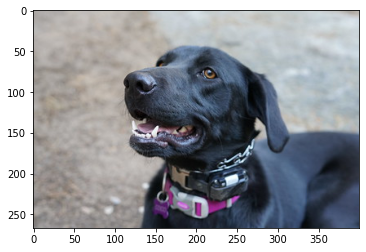

In [14]:
# Show inference speed on PaddlePaddle model
start = time.perf_counter()
for _ in range(num_images):
    result = next(classifier.predict(np.array(image)))
end = time.perf_counter()
time_ir = end - start
print(
    f"PaddlePaddle model on CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}\n"
)
print("PaddlePaddle result:")
class_names = result[0]['label_names']
scores = result[0]['scores']
for class_name, softmax_probability in zip(class_names, scores):
    print(f"{class_name}, {softmax_probability:.5f}")
plt.imshow(image);

OpenVINO IR model in OpenVINO Runtime (CPU): 0.0029 seconds per image, FPS: 349.29

OpenVINO result:
Labrador retriever, 0.75138
German short-haired pointer, 0.02373
Great Dane, 0.01848
Rottweiler, 0.01435
flat-coated retriever, 0.01144


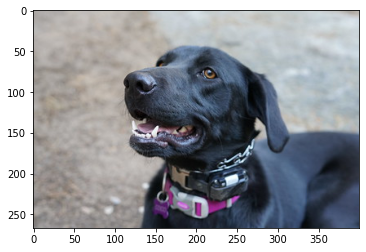

In [15]:
# Show inference speed on OpenVINO IR model
compiled_model = ie.compile_model(model=model, device_name="CPU")
output_layer = compiled_model.output(0)


start = time.perf_counter()
input_image = process_image(np.array(image))[None,]
for _ in range(num_images):
    ie_result = compiled_model([input_image])[output_layer][0]
    top_indices = np.argsort(ie_result)[-5:][::-1]
    top_softmax = ie_result[top_indices]

end = time.perf_counter()
time_ir = end - start

print(
    f"OpenVINO IR model in OpenVINO Runtime (CPU): {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)
print()
print("OpenVINO result:")
for index, softmax_probability in zip(top_indices, top_softmax):
    print(f"{class_id_map[index]}, {softmax_probability:.5f}")
plt.imshow(image);

## References

* [PaddleClas](https://github.com/PaddlePaddle/PaddleClas)
* [OpenVINO PaddlePaddle support](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_Paddle.html)
* [OpenVINO Model Optimizer Documentation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model_General.html)